In [1]:
import wandb
wandb.login()  # Opens a browser once to authenticate


wandb: Currently logged in as: analiju (analiju-paris) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models import resnet50
from itertools import product
import numpy as np
import random
import copy
import os, ssl, zipfile, urllib
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

LOCAL_OR_COLAB = "LOCAL"
SEED           = 42
NUM_EPOCHS     = 100
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_FRAC = 0.7
VAL_FRAC   = 0.15
TEST_FRAC  = 0.15

# hyperparameter grid
BATCH_SIZES = [256, 512] 
LRS = [1e-4]

if LOCAL_OR_COLAB == "LOCAL":
    DATA_DIR = "/users/c/carvalhj/datasets/EuroSAT_RGB/"
else:
    data_root = "/content/EuroSAT_RGB"
    zip_path  = "/content/EuroSAT.zip"
    if not os.path.exists(data_root):
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(
            "https://madm.dfki.de/files/sentinel/EuroSAT.zip", zip_path
        )
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall("/content")
        os.rename("/content/2750", data_root)
    DATA_DIR = data_root

NUM_WORKERS = 4 

In [ ]:
def get_data_loaders(data_dir, batch_size):

    base_tf = transforms.ToTensor()
    ds_all = datasets.ImageFolder(root=data_dir, transform=base_tf)
    labels = np.array(ds_all.targets)   # numpy array of shape (N,)
    num_classes = len(ds_all.classes)
    total_count = len(ds_all)
    print(f"Total samples in folder: {total_count}, classes: {ds_all.classes}")

    train_idx, val_idx, test_idx = get_split_indexes(labels, total_count)

    def class_props(indices):
        cts = np.bincount(labels[indices], minlength=num_classes)
        return cts / len(indices)

    prop_train = class_props(train_idx)
    prop_val   = class_props(val_idx)
    prop_test  = class_props(test_idx)

    plot_proportions(ds_all, num_classes, prop_train, prop_val, prop_test)

    train_subset_for_stats = Subset(ds_all, train_idx)
    mean, std = compute_mean_std(train_subset_for_stats, batch_size)
    print(f"Computed mean: {mean}")
    print(f"Computed std:  {std}")

    tf_final = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    #  full ImageFolder but now with normalization baked in
    ds_all_norm = datasets.ImageFolder(root=data_dir, transform=tf_final)

    train_ds = Subset(ds_all_norm, train_idx)
    val_ds   = Subset(ds_all_norm, val_idx)
    test_ds  = Subset(ds_all_norm, test_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))

    return train_loader, val_loader, test_loader, num_classes

def get_split_indexes(labels, total_count):
    n_train = int(np.floor(TRAIN_FRAC * total_count))
    n_temp = total_count - n_train   # this is val + test

    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        train_size=n_train,
        test_size=n_temp,
        random_state=SEED
    )
    # Train and temp(val+test) indices
    train_idx, temp_idx = next(sss1.split(np.zeros(total_count), labels))

    n_val = int(np.floor(VAL_FRAC * total_count))
    n_test = total_count - n_train - n_val
    assert n_temp == n_val + n_test, "Fractions must sum to 1."

    labels_temp = labels[temp_idx]

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        train_size=n_val,
        test_size=n_test,
        random_state=SEED
    )
    val_idx_in_temp, test_idx_in_temp = next(sss2.split(np.zeros(len(temp_idx)), labels_temp))

    val_idx = temp_idx[val_idx_in_temp]
    test_idx = temp_idx[test_idx_in_temp]

    assert len(train_idx) == n_train
    assert len(val_idx) == n_val
    assert len(test_idx) == n_test

    print(f"Stratified split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")
    return train_idx,val_idx,test_idx

def plot_proportions(ds_all, num_classes, prop_train, prop_val, prop_test):
    print(f"Class proportions (%):")
    print(f"  Train: {100 * prop_train}")
    print(f"   Val:  {100 * prop_val}")
    print(f"  Test:  {100 * prop_test}")
    x = np.arange(num_classes)
    width = 0.25
    plt.figure(figsize=(10, 5))
    plt.bar(x - width, 100 * prop_train, width, label='Train')
    plt.bar(x,         100 * prop_val,   width, label='Val')
    plt.bar(x + width, 100 * prop_test,  width, label='Test')
    plt.xlabel('Class Index')
    plt.ylabel('Proportion (%)')
    plt.title('Stratified Class Proportions in Train/Val/Test')
    plt.xticks(x, ds_all.classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


>>> Testing BS=256, LR=1.0e-04
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=21600, val=2700, test=2700
Class proportions (%):
  Train: [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
   Val:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
  Test:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]


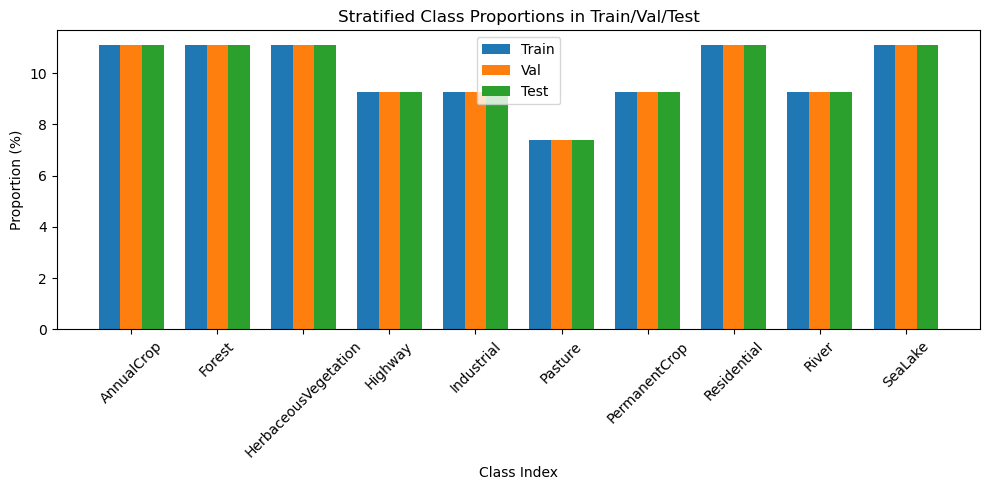

Computed mean: [0.3441457152366638, 0.3800986111164093, 0.40766361355781555]
Computed std:  [0.09299743920564651, 0.06464490294456482, 0.054139167070388794]


  Ep1/100: train=49.7%  val=59.7%
  Ep2/100: train=66.8%  val=69.0%
  Ep3/100: train=71.7%  val=69.9%
  Ep4/100: train=73.8%  val=70.3%
  Ep5/100: train=74.5%  val=70.3%
  Ep6/100: train=75.0%  val=70.6%
  Ep7/100: train=75.3%  val=70.4%
  Ep8/100: train=75.4%  val=70.1%
  Ep9/100: train=75.2%  val=70.4%
  Ep10/100: train=75.8%  val=70.7%
  Ep11/100: train=75.5%  val=70.4%
  Ep12/100: train=75.7%  val=69.7%
  Ep13/100: train=75.1%  val=70.7%
  Ep14/100: train=75.5%  val=70.1%
  Ep15/100: train=75.2%  val=70.4%
  Ep16/100: train=75.4%  val=70.7%
  Ep17/100: train=75.1%  val=70.7%
  Ep18/100: train=75.2%  val=69.9%
  Ep19/100: train=75.2%  val=70.6%
  Ep20/100: train=75.3%  val=70.3%
  Ep21/100: train=75.6%  val=70.1%
  Ep22/100: train=75.6%  val=70.4%
  Ep23/100: train=75.6%  val=70.8%
  Ep24/100: train=75.4%  val=70.4%
  Ep25/100: train=75.6%  val=70.1%
  Ep26/100: train=75.4%  val=70.2%
  Ep27/100: train=75.4%  val=70.5%
  Ep28/100: train=75.5%  val=70.1%
  Ep29/100: train=75.5%  val=

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
train_acc,▁▅▆▇▇█▇█████████████████████████▇█▇█████
train_loss,▇▆▄▅▅▄▄▅▆▃▃▃▆▃▂▄▅▃▃▇▂▆▄▄▂▁▁▅▅▂▃▃▄▄▅▃▅▄█▆
val_acc,▁▇████▇███████████████████▇█████████████
epoch,100
train_acc,75.55093
train_loss,0.69381
val_acc,70.2963



>>> Testing BS=512, LR=1.0e-04
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=21600, val=2700, test=2700
Class proportions (%):
  Train: [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
   Val:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
  Test:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]


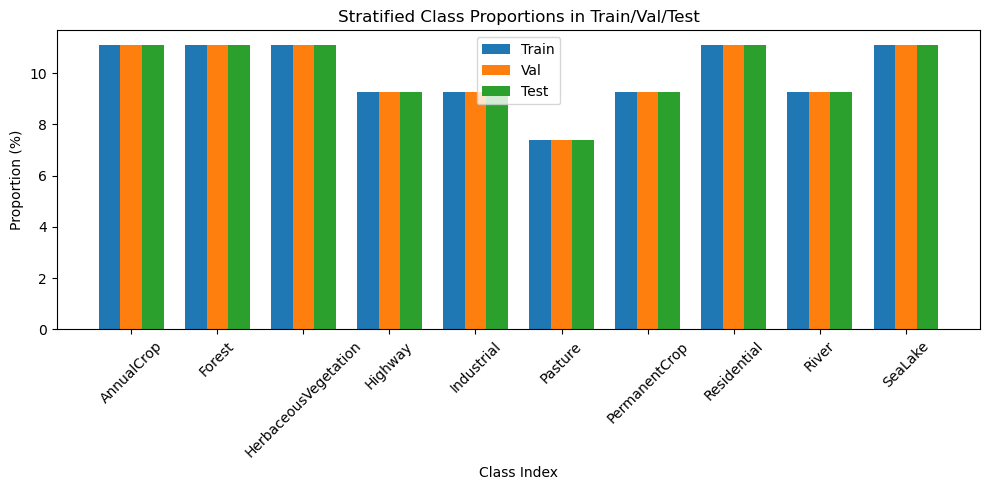

Computed mean: [0.3441457152366638, 0.3800985515117645, 0.40766361355781555]
Computed std:  [0.09299741685390472, 0.06464490294456482, 0.05413917079567909]


  Ep1/100: train=44.9%  val=51.6%
  Ep2/100: train=63.6%  val=66.4%
  Ep3/100: train=70.9%  val=69.0%
  Ep4/100: train=75.2%  val=71.5%
  Ep5/100: train=78.0%  val=72.0%
  Ep6/100: train=80.1%  val=72.8%
  Ep7/100: train=81.0%  val=72.7%
  Ep8/100: train=82.2%  val=72.1%
  Ep9/100: train=83.2%  val=72.4%
  Ep10/100: train=83.7%  val=72.6%
  Ep11/100: train=83.7%  val=72.9%
  Ep12/100: train=83.7%  val=72.7%
  Ep13/100: train=83.8%  val=72.7%
  Ep14/100: train=84.1%  val=72.7%
  Ep15/100: train=83.9%  val=73.2%
  Ep16/100: train=84.0%  val=72.4%
  Ep17/100: train=84.1%  val=72.9%
  Ep18/100: train=84.0%  val=72.7%
  Ep19/100: train=84.2%  val=73.3%
  Ep20/100: train=83.8%  val=72.7%
  Ep21/100: train=83.8%  val=72.2%
  Ep22/100: train=83.8%  val=73.0%
  Ep23/100: train=83.7%  val=72.5%
  Ep24/100: train=83.7%  val=73.1%
  Ep25/100: train=83.8%  val=72.3%
  Ep26/100: train=83.6%  val=73.0%
  Ep27/100: train=84.3%  val=72.7%
  Ep28/100: train=84.3%  val=72.9%
  Ep29/100: train=84.1%  val=

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
train_acc,▁▅▆██████████▇████████▇██████████▇█████▇
train_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▇▇▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇██▇▇▇███▇▇█▇▇███▇▇
epoch,100
train_acc,83.95833
train_loss,0.48023
val_acc,72.59259



>>> Best config: BS=512, LR=1.0e-04, val=72.6%
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=21600, val=2700, test=2700
Class proportions (%):
  Train: [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
   Val:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
  Test:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]


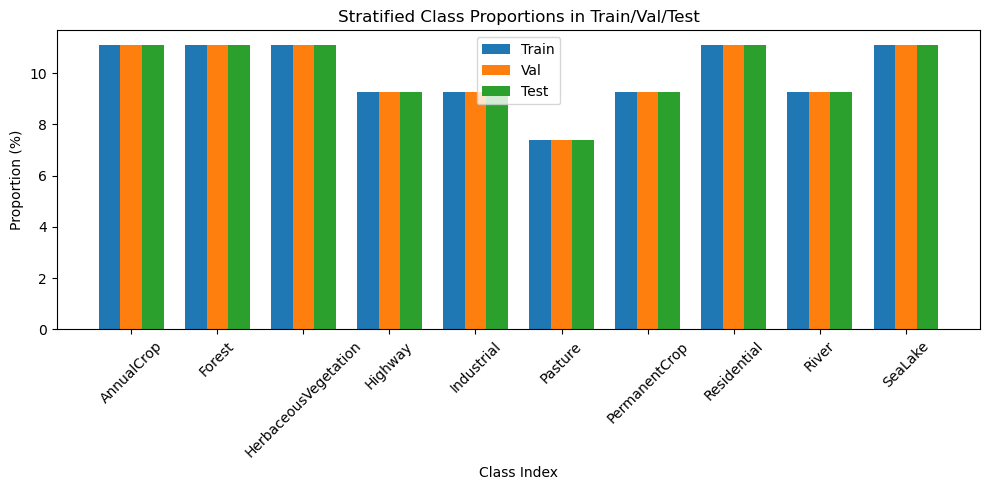

Computed mean: [0.3441457152366638, 0.3800985515117645, 0.40766361355781555]
Computed std:  [0.09299741685390472, 0.06464490294456482, 0.05413917079567909]

>>> Running linear probe on frozen backbone
  Probe Ep1/100: train=50.5%
  Probe Ep2/100: train=75.3%
  Probe Ep3/100: train=77.5%
  Probe Ep4/100: train=77.7%
  Probe Ep5/100: train=78.1%
  Probe Ep6/100: train=78.7%
  Probe Ep7/100: train=78.0%
  Probe Ep8/100: train=78.2%
  Probe Ep9/100: train=78.7%
  Probe Ep10/100: train=78.8%
  Probe Ep11/100: train=78.6%
  Probe Ep12/100: train=78.5%
  Probe Ep13/100: train=78.6%
  Probe Ep14/100: train=78.9%
  Probe Ep15/100: train=78.9%
  Probe Ep16/100: train=78.9%
  Probe Ep17/100: train=78.7%
  Probe Ep18/100: train=78.4%
  Probe Ep19/100: train=78.7%
  Probe Ep20/100: train=79.0%
  Probe Ep21/100: train=78.9%
  Probe Ep22/100: train=78.6%
  Probe Ep23/100: train=78.7%
  Probe Ep24/100: train=78.7%
  Probe Ep25/100: train=78.8%
  Probe Ep26/100: train=79.2%
  Probe Ep27/100: train=79.1

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

def compute_mean_std(dataset, batch_size):
    loader = DataLoader(dataset, batch_size, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    n_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples
    return mean.tolist(), std.tolist()

def build_model(n_cls, pretrained=False):
    m = resnet50(weights=None if not pretrained else "DEFAULT")
    m.fc = nn.Linear(m.fc.in_features, n_cls)
    return m.to(DEVICE)

def train_one_epoch(model, loader, opt, crit, sched=None):
    model.train()
    tot_loss, corr, tot = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        logits = model(xb)

        loss   = crit(logits, yb)
        loss.backward()
        opt.step()
        if sched: sched.step()
        tot_loss += loss.item()
        preds    = logits.argmax(dim=1)
        corr    += (preds==yb).sum().item()
        tot     += yb.size(0)
        avg_loss = tot_loss / len(loader)

    avg_loss = tot_loss / len(loader)
    acc = 100.0 * corr / tot
    return avg_loss, acc

def evaluate(model, loader):
    model.eval()
    corr, tot = 0,0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb).argmax(dim=1)
            corr += (preds==yb).sum().item()
            tot  += yb.size(0)
    return 100 * corr / tot

def hyperparam_search(pretrained=True):
    best_val = -1.0
    best_cfg = None
    best_model = None

    for bs, lr in [(b, l) for b in BATCH_SIZES for l in LRS]:
        print(f"\n>>> Testing BS={bs}, LR={lr:.1e}")
        set_seed(SEED)
        tr_dl, val_dl, te_dl, n_cls = get_data_loaders(DATA_DIR, bs)
        model = build_model(n_cls, pretrained=pretrained)

        opt   = optim.Adam(model.parameters(), lr=lr)
        sched = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.9)
        crit  = nn.CrossEntropyLoss()

        # Start a W&B run
        wandb_run = wandb.init(
            project="eurosat-supervised-scratch-grid-search",
            name=f"BS{bs}_LR{lr:.0e}",
            config={
                "batch_size": bs,
                "learning_rate": lr,
                "epochs": NUM_EPOCHS,
                "pretrained": pretrained,
            }
        )

        for ep in range(NUM_EPOCHS):
            tr_loss, tr_acc = train_one_epoch(model, tr_dl, opt, crit, sched)
            # Compute validation loss & accuracy in one pass
            model.eval()
            val_loss, corr, tot = 0.0, 0, 0
            with torch.no_grad():
                for xb, yb in val_dl:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    logits = model(xb)
                    loss = crit(logits, yb)
                    val_loss += loss.item()
                    preds = logits.argmax(dim=1)
                    corr += (preds == yb).sum().item()
                    tot  += yb.size(0)
            val_loss /= len(val_dl)
            val_acc = 100.0 * corr / tot

            print(f"  Ep{ep+1}/{NUM_EPOCHS}: train_acc={tr_acc:.1f}%  val_acc={val_acc:.1f}%  val_loss={val_loss:.4f}")

            # Log metrics to W&B
            wandb.log({
                "epoch":       ep + 1,
                "train_loss":  tr_loss,
                "train_acc":   tr_acc,
                "val_loss":    val_loss,
                "val_acc":     val_acc
            })

        wandb_run.finish()

        # Only use val_acc to pick best
        if val_acc > best_val:
            best_val   = val_acc
            best_cfg   = (bs, lr)
            best_model = copy.deepcopy(model)

    print(f"\n>>> Best config: BS={best_cfg[0]}, LR={best_cfg[1]:.1e}, val_acc={best_val:.1f}%")
    return best_cfg, best_model

def linear_probe(frozen_model, train_dl, test_dl, lr):
    for p in frozen_model.parameters():
        p.requires_grad = False
    # new head
    n_in = frozen_model.fc.in_features
    n_out = frozen_model.fc.out_features
    frozen_model.fc = nn.Linear(n_in, n_out).to(DEVICE)

    opt = optim.Adam(frozen_model.fc.parameters(), lr=lr)
    sched = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.9)

    crit = nn.CrossEntropyLoss()

    print("\n>>> Running linear probe on frozen backbone")
    for ep in range(NUM_EPOCHS):
        loss, acc = train_one_epoch(frozen_model, train_dl, opt, crit, sched=sched)
        print(f"  Probe Ep{ep+1}/{NUM_EPOCHS}: train={acc:.1f}%")
    test_acc = evaluate(frozen_model, test_dl)
    print(f"Probe test acc: {test_acc:.1f}%")
    wandb.init(
        project="eurosat-supervised-scratch-linear-probe",
        name=f"BS{train_dl.batch_size}_LR{lr:.0e}_probe",
        config={
            "batch_size": train_dl.batch_size,
            "learning_rate": lr,
            "epochs": NUM_EPOCHS,
            "pretrained": False,
            "probe": True
        }
    )
    wandb.log({"probe_test_acc": test_acc})

    return test_acc



In [ ]:
# Main

best_cfg, best_model = hyperparam_search(pretrained=False)

bs, lr = best_cfg
tr_dl, val_dl, te_dl, n_cls = get_data_loaders(DATA_DIR, bs)

probe_acc = linear_probe(best_model, tr_dl, te_dl, lr)

print("\n>>> Retraining final model on TRAIN+VAL combined with best hyperparameters")
combined_dataset = ConcatDataset([tr_dl.dataset, val_dl.dataset])
combined_dl = DataLoader(combined_dataset, batch_size=bs, shuffle=True, num_workers=4)

set_seed(SEED)
final_model = build_model(n_cls, pretrained=False)
opt_final = optim.Adam(final_model.parameters(), lr=lr)
sched_final = optim.lr_scheduler.StepLR(opt_final, step_size=10, gamma=0.9)
crit_final  = nn.CrossEntropyLoss()

for ep in range(NUM_EPOCHS):
    loss, acc = train_one_epoch(final_model, combined_dl, opt_final, crit_final, sched=sched_final)
    print(f"  Final Retrain Ep{ep+1}/{NUM_EPOCHS}: train_acc={acc:.1f}%")

final_test_acc = evaluate(final_model, te_dl)
print(f"Final model test accuracy: {final_test_acc:.1f}%")

wandb.init(
    project="eurosat-supervised-scratch-final",
    name=f"BS{bs}_LR{lr:.0e}_final",
    config={
        "batch_size":    bs,
        "learning_rate": lr,
        "epochs":        NUM_EPOCHS,
        "pretrained":    False,
        "final_retrain": True
    }
)
wandb.log({"final_test_acc": final_test_acc})

In [ ]:


# ─── MAIN ───────────────────────────────────────────────────────────────────────
best_cfg, best_model = hyperparam_search(pretrained = False)
# rebuild loaders once more so we have the same splits
bs, lr = best_cfg
tr_dl, val_dl, te_dl, _ = get_data_loaders(DATA_DIR, bs)

# Option A: probe on just the original training split
probe_acc = linear_probe(best_model, tr_dl, te_dl, lr)

In [5]:
best_cfg, best_model 


((512, 0.0001),
 ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256,

In [6]:
torch.save(best_model.state_dict(), "best_model.pt")
artifact = wandb.Artifact("best_model", type="model")
artifact.add_file("best_model.pt")
wandb.log_artifact(artifact)


<Artifact best_model>